### Organise file structure to BIDS and create a holdout split

Reference documentation links:
* IMAGEN's native documentation: https://imagen-europe.com/resources/imagen-dataset/documentation/
* Our local documentation: https://github.com/ritterlab/deepMRI/wiki/IMAGEN
* Their github repositories: https://github.com/imagen2
* Evert's initial analysis (lab-rotation): https://github.com/ritterlab/imagen_labrotation
* Evert's thesis: https://github.com/evertdeman/imagen_thesis
* Latest IMAGEN publications: https://imagen-europe.com/resources/publications/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, subprocess
from glob import glob 
from os.path import join

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set(style="darkgrid", color_codes=False)

from tqdm.notebook import tqdm

In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/ritter/roshan/workspace/nitorch')
import nitorch
from nitorch.data import load_nifti, show_brain

from plotGraphs import plotGraph

In [4]:
# Specify the path to the data
DATA_DIR = "/ritter/share/data/IMAGEN/"
RAW_DIR = "/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/"
BIDS_DIR = "/ritter/share/data/IMAGEN/IMAGEN_BIDS/"

In [5]:
# List of valid subject IDs provided by IMAGEN at https://github.com/imagen2/imagen_databank/wiki/Valid-identifiers
with open(join(RAW_DIR, "../documentation/Valid-identifiers.txt")) as f:
    valid_ids = set([int(i) for i in f])
    print("Total valid subject IDs listed initially by IMAGEN =", len(valid_ids))

Total valid subject IDs listed initially by IMAGEN = 2529


### 1. Convert the data structure into [BIDS format](https://github.com/ritterlab/deepMRI/wiki/BIDS)

#### collect all imaging files from IMAGEN_RAW into a dataframe

In [100]:
tp = ["BL", "FU2", "FU3"][2]

In [101]:
imaging_types = [ # (BIDS shortname, path glob in raw dir)
    ("T1w",           glob(RAW_DIR+tp+"/imaging/nifti/*/SessionA/ADNI_MPRAGE/*.nii.gz")),
    ("rec-fs-r1_T1w", glob(RAW_DIR+tp+"/imaging/freesurfer/*/mri/brainmask.mgz")),
    ("rec-fs-r2_T1w", glob(RAW_DIR+tp+"/imaging/freesurfer/*/mri/brain.finalsurfs.mgz")),
#     ("rec-FAsk_DTI", glob(RAW_DIR+tp+"/imaging/tbss_dti/classic/stats/split_FA_skeleton/*_skelFA.nii.gz")),
#     ("rec-MDsk_DTI", glob(RAW_DIR+tp+"/imaging/tbss_dti/classic/stats/split_MD_skeleton/*_skelMD.nii.gz")),
    ("FLAIR",         glob(RAW_DIR+tp+"/imaging/nifti/*/SessionA/FLAIR/*.nii.gz")),
    ("T2",            glob(RAW_DIR+tp+"/imaging/nifti/*/SessionA/T2/*.nii.gz")),
    ("rec-fs-r1-MNInl_T1w", glob(BIDS_DIR+f"sub-*/{tp}/anat/*rec-fs-r1-MNInl_T1w*")),
#     ("rec-FAsk_DTI", glob(DATA_DIR+f"IMAGEN_DTI_BIDS/sub-*/{tp}/FA*/*FA*.nii.gz")),
#     ("rec-MDsk_DTI", glob(DATA_DIR+f"IMAGEN_DTI_BIDS/sub-*/{tp}/MD*/*MD*.nii.gz")),
]

print("For time-point =", tp, "\n--------------------")
for i in imaging_types:
    print(f"n({i[0]})=", len(i[1]))

For time-point = FU3 
--------------------
n(T1w)= 1182
n(rec-fs-r1_T1w)= 1179
n(rec-fs-r2_T1w)= 1179
n(FLAIR)= 577
n(T2)= 578
n(rec-fs-r1-MNInl_T1w)= 1179


In [102]:
df = pd.DataFrame(index=valid_ids)
df.index.rename("ID", inplace=True)

df["time_point"]=tp
df["subjectID"]=np.NaN
# set NaN for all other cols
cols = [(f"path_{name}".replace("rec-",""), f"rawpath_{name}".replace("rec-","")) for name, _ in imaging_types]
for colpair in cols:
    for c in colpair:
        df[c]=np.NaN

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2529 entries, 66576392 to 16408573
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time_point               2529 non-null   object 
 1   subjectID                0 non-null      float64
 2   path_T1w                 0 non-null      float64
 3   rawpath_T1w              0 non-null      float64
 4   path_fs-r1_T1w           0 non-null      float64
 5   rawpath_fs-r1_T1w        0 non-null      float64
 6   path_fs-r2_T1w           0 non-null      float64
 7   rawpath_fs-r2_T1w        0 non-null      float64
 8   path_FLAIR               0 non-null      float64
 9   rawpath_FLAIR            0 non-null      float64
 10  path_T2                  0 non-null      float64
 11  rawpath_T2               0 non-null      float64
 12  path_fs-r1-MNInl_T1w     0 non-null      float64
 13  rawpath_fs-r1-MNInl_T1w  0 non-null      float64
dtypes: float64(13

In [15]:
# example dirs of each imaging type
# for name,p in imaging_types:
#     print(name, ":\t", p[0])

In [16]:
for imaging_type, path_globs in imaging_types:
    if path_globs:
        colname = imaging_type.replace("rec-","")    
        filetype = "mgz" if path_globs[0][-3:]=="mgz" else "nii.gz"

        print("adding {} file info into dataframe...".format(colname))
        for path in tqdm(path_globs): 

            folders = path.split("/")
            time_point = tp
            if folders[5] != "IMAGEN_RAW":
                subjectID = folders[6].replace("sub-","")
            elif folders[9]=="tbss_dti":
                subjectID = folders[-1].split("_")[0]
            else: # expected to be a BIDS structure 
                subjectID = folders[10]
            ID = int(subjectID)

            filename = f"sub-{subjectID}_ses-{time_point}_{imaging_type}.{filetype}"
            new_path = join(BIDS_DIR, 
                            "sub-{}".format(subjectID), 
                            time_point, 
                            "anat",
                            filename)

            df.loc[ID, ["subjectID", f"rawpath_{colname}", f"path_{colname}"]] = ["sub-"+subjectID, path, new_path]
#         print(os.path.isfile(df.loc[ID, f"rawpath_{colname}"])) # sanity check

adding T1w file info into dataframe...



adding fs-r1_T1w file info into dataframe...



adding fs-r2_T1w file info into dataframe...



adding FLAIR file info into dataframe...



adding T2 file info into dataframe...



adding fs-r1-MNInl_T1w file info into dataframe...


In [17]:
# 1) check that the "non-Null" values have increased because of any newly downloaded data 
# 2) check 'path_*' and 'rawpath_*' have same counts
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2529 entries, 66576392 to 16408573
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   time_point               2529 non-null   object
 1   subjectID                1182 non-null   object
 2   path_T1w                 1182 non-null   object
 3   rawpath_T1w              1182 non-null   object
 4   path_fs-r1_T1w           1179 non-null   object
 5   rawpath_fs-r1_T1w        1179 non-null   object
 6   path_fs-r2_T1w           1179 non-null   object
 7   rawpath_fs-r2_T1w        1179 non-null   object
 8   path_FLAIR               577 non-null    object
 9   rawpath_FLAIR            577 non-null    object
 10  path_T2                  578 non-null    object
 11  rawpath_T2               578 non-null    object
 12  path_fs-r1-MNInl_T1w     1179 non-null   object
 13  rawpath_fs-r1-MNInl_T1w  1179 non-null   object
dtypes: object(14)
memory usage: 3

#### copy files from IMAGEN_RAW to IMAGEN_BIDS structure

In [63]:
# flatten all paths info into list-pairs
paths=[]
rawpaths=[]
for colpair in cols:
    paths.extend(df[colpair[0]].dropna().tolist())
    rawpaths.extend(df[colpair[1]].dropna().tolist())

len(paths), len(rawpaths), paths[0], rawpaths[0]

(4729,
 4729,
 '/ritter/share/data/IMAGEN/IMAGEN_BIDS/sub-000069795852/FU3/anat/sub-000069795852_ses-FU3_T1w.nii.gz',
 '/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU3/imaging/nifti/000069795852/SessionA/ADNI_MPRAGE/000069795852_ADNIMPRAGE.nii.gz')

In [64]:
# parallelize and copy from rawpath to new 
from multiprocessing import Pool
import subprocess

def wrapper(i):
    # first check if it already exists
    if not os.path.isfile(paths[i]):
        newdir = os.path.dirname(paths[i])
        if not os.path.exists(newdir):
            os.makedirs(newdir)
        subprocess.run(["cp", rawpaths[i], paths[i]])

with Pool(10) as p:
    p.map(wrapper, range(len(paths)))

#### Save a priliminary participants_\*.csv for each time-point

In [22]:
df_save = df[[c for c in df.columns if not "rawpath" in c]]
df_save.sort_index().to_csv(f"{BIDS_DIR}participants_{tp}.csv")

In [23]:
df_save = pd.read_csv(f"{BIDS_DIR}participants_{tp}.csv", index_col="ID")

for _, s in df_save.iterrows():
    for c in s:
        if isinstance(c, str) and "/"==c[0]:
            if not os.path.isfile(c):
                print("{} was not copied".format(c))
print("all files were copied successfully")

all files were copied successfully


In [24]:
del df, df_save

#### Store freesurfer stats files in BIDS

In [83]:
for tp in ["BL", "FU1",  "FU2", "FU3"]:
    fs_stats = pd.DataFrame()
    fs_stats.index.names = ["ID"]

    for f in glob(join(DATA_DIR, "IMAGEN_RAW/2.7/{}/imaging/freesurfer/*.tsv".format(tp))):
        dfx = pd.read_csv(f, sep="\t")
        # the first column always has the subject ID
        dfx = dfx.set_index(dfx.columns[0])
        dfx.index.names = ["ID"]
        fs_stats = fs_stats.merge(dfx, "outer", on="ID")
        
    fs_stats.sort_index().to_csv(f"{BIDS_DIR}fs-stats_{tp}.csv")

### 2. Add basic demographic data to all <participants_\*.csv> files.

In [25]:
df_demo = pd.read_csv(join(RAW_DIR, "FU3/participants/IMAGEN_demographics.csv"), dtype={"PSC2":int})
df_demo = df_demo.rename(columns={"PSC2" : "ID", "recruitment centre":"site"})
df_demo2 = pd.read_csv(join(RAW_DIR, "IMAGEN_stats_from_db.csv"), sep=";", dtype={"code_in_study":int})
df_demo2 = df_demo2.rename(columns={"code_in_study" : "ID"})[["ID", "gender", "handedness"]]
df_demo = pd.merge(df_demo, df_demo2, on='ID', how="inner")
print("Total subjects in demographics table =", len(df_demo))
del df_demo2

Total subjects in demographics table = 2315


In [26]:
df = pd.read_csv(f"{BIDS_DIR}participants_{tp}.csv", index_col="ID")
# merge the demographic data to all participants_*.csv files
df = pd.merge(df.reset_index(), df_demo, on='ID', how="outer")
# drop rows which don't have any imaging data
df = df.dropna(how="all", subset=["sex", "site"])
# overwrite previous file
df.sort_index().to_csv(f"{BIDS_DIR}participants_{tp}.csv")

In [11]:
# drop columns from FU2 and BL sMRI_derivatives files: {'CorticalWhiteMatterVol', 'lhCorticalWhiteMatterVol', 'rhCorticalWhiteMatterVol'}
# for f in glob(f"{BIDS_DIR}/sMRI-derivatives_*.csv"):
#     df = pd.read_csv(f, index_col="ID")
# #    display(df)
#     drop_cols = df.filter(like="CorticalWhiteMatterVol").columns.to_list()
#     drop_cols.extend(df.filter(like="Unnamed").columns.to_list())
#     print(f"dropping columns {drop_cols} from {f}")
#     df = df.drop(columns=drop_cols)
#     df.to_csv(f)

### 3. Create holdout / report / test split:
    * Take measures to prevent data leakage between training and holdout set
    * Lock the holdout set from read/write access

<!-- #### check which site the siblings belong, to ensure they don't get distributed between the training and holdout splits -->

In [144]:
# # demographic data
df = pd.read_csv(join(RAW_DIR, "FU3/participants/IMAGEN_demographics.csv"))
df = df.set_index("PSC2")
print("Total subject IDs included in the final demographics file =", len(df))

# create a column for siblings
df["has_sibling"]= np.nan
with open(join(RAW_DIR, "FU3/participants/IMAGEN_siblings.txt")) as f:
    siblings = []
    for sibling_pairs in f:
        sibling1, sibling2 = sibling_pairs.split(",")
        sibling1 = int(sibling1)
        sibling2 = int(sibling2.replace("\n",""))
        df.loc[sibling1, "has_sibling"] = sibling2
        df.loc[sibling2, "has_sibling"] = sibling1

print("Subjects with siblings =", df.has_sibling.isna().value_counts()[False]) 

# check which 'site' the siblings belong to
print("Sibling distributions per recruitment site:\n",
df[~df.has_sibling.isna()]['recruitment centre'].value_counts())

Total subject IDs included in the final demographics file = 2315
Subjects with siblings = 40
Sibling distributions per recruitment site:
 PARIS         32
LONDON         4
NOTTINGHAM     2
DUBLIN         2
Name: recruitment centre, dtype: int64


#### ensure longitudinal data from same subjects don't get distributed across the training and holdout splits (avoid data leakage)

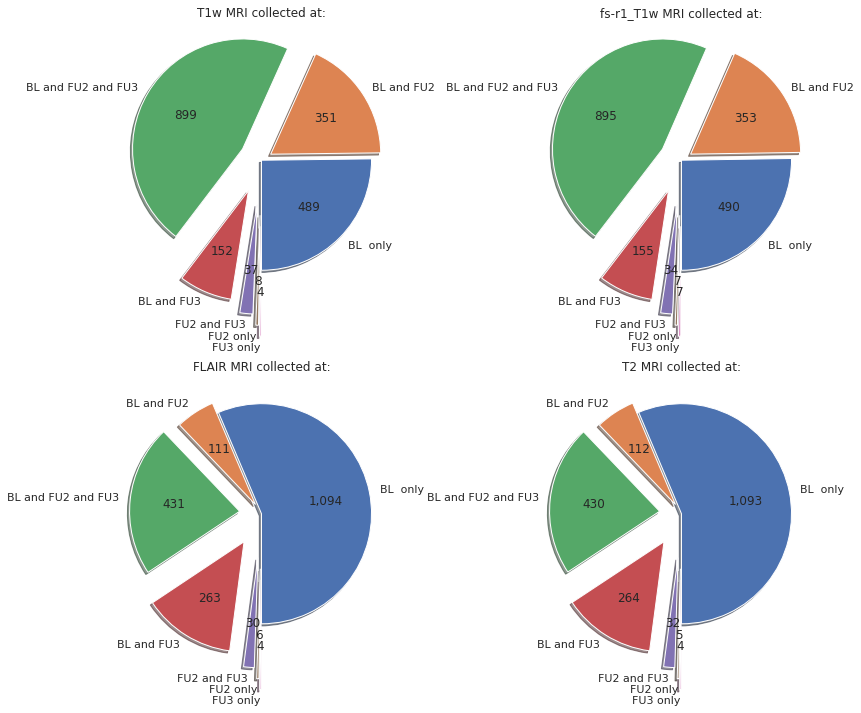

In [8]:
d.plot_timepoint_dists()

Conclusion: Use only the ~1000 subjects who have imaging data at all three timepoints for test set selection

To prevent site information from acting as a confound, I could set aside the images from one single site as the holdout set and perform n-fold CV with the remaining site. Which site should I set as the test set?

~~Conclusion: Set aside NOTTINGHAM data as holdout set as it is ~15% of entire data~~

In [166]:
# dfi = pd.read_csv(f"{BIDS_DIR}participants_{tp}.csv", index_col="ID")
# randomly sample some data samples as the holdout
# dfi = dfi.drop(columns=["Unnamed: 0"])
# mark subjects who are to be the holdout set
# dfi["holdout"] = #(dfi["site"]=="NOTTINGHAM")
# dfi.sort_index().to_csv(f"{BIDS_DIR}participants_{tp}.csv")

#### Conclusion: Randomly select 20% of the subjects aside as holdout set~~

In [159]:
d = Imagen(exclude_holdout=False)
# valid_ids = set(d.df.index) | set(d.df_holdout.index)
for f in sorted(glob(BIDS_DIR+"sMRI-derivatives_*.csv")):
    df = pd.read_csv(f)
    usable = set(df.dropna()["ID"])
    print(f.split("/")[-1].replace(".csv", "").replace("sMRI-derivatives_",""), len(df), len(usable))
    valid_ids &= usable
print("subset of subjects who appeared at all 3 time points:", len(valid_ids))

BL 2106 1691
FU2 1423 1341
FU3 1182 1113
subset of subjects who appeared at all 3 time points: 737


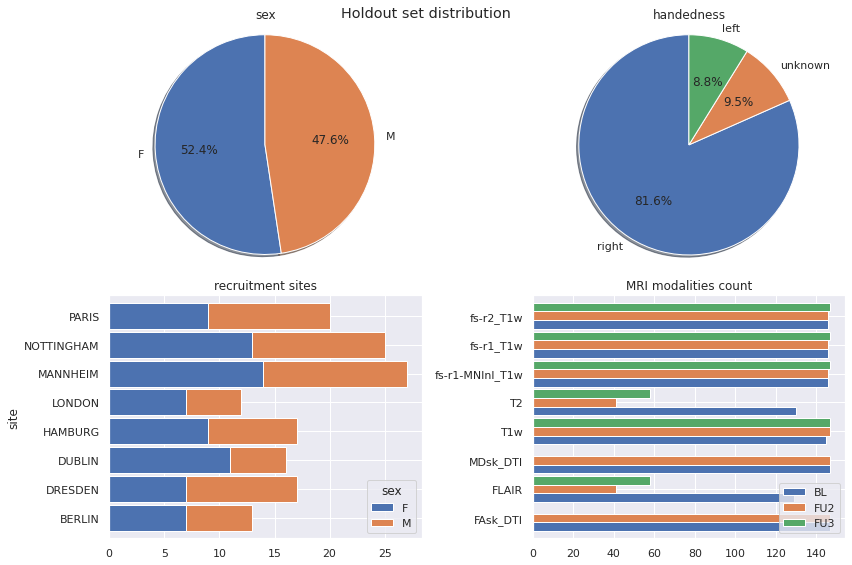

In [164]:
np.random.seed(42)
holdout = np.random.choice(list(valid_ids), size=(len(valid_ids)//5), replace=False)
# stats of the holdout subjects
d.df = d.df.loc[holdout]
d.plot_demographics()
plt.suptitle("Holdout set distributions:")
plt.show()

In [180]:
for f in glob(f"{BIDS_DIR}/participants_*.csv"):
    dfi = pd.read_csv(f, index_col="ID")
    unnamed_cols = dfi.filter(like="Unnamed").columns
    dfi = dfi.drop(columns=unnamed_cols)
    dfi["holdout"] = False
    dfi.loc[holdout, "holdout"] = True
#     display(dfi.holdout.value_counts())
#     dfi.to_csv(f)

In [9]:
# df1 = df.swaplevel(axis=1)[["path_fs-recon1_T1w", "sex", "site"]].droplevel(1, axis=1)
# # select only subjects with MRI available at all 3 time_points  
# df1 = df1.loc[~df1["path_fs-recon1_T1w"].isnull().any(axis=1)]

# f,axes = plt.subplots(1,2, figsize=(12,4))
# plotGraph(df1, "sex", plt_type="pie", ax=axes[0]) 
# df1[[ "sex", "site"]].value_counts().unstack().T.plot.barh(stacked=True, ax=axes[1])
# plt.tight_layout()
# plt.show()

#### Remove read permission from hold out set. 
#### Also edit read/write permissions on all final files in BIDS directory.

In [10]:
! find /ritter/share/data/IMAGEN/IMAGEN_BIDS/ -type f -exec chmod 554 {} \;

In [31]:
! find /ritter/share/data/IMAGEN/IMAGEN_BIDS/ -type d -exec chmod 755 {} \;

In [12]:
# remove read permission from holdout set
d._lock_holdout()

removed read permission for 349 subject dirs


In [13]:
# d._unlock_holdout()

In [14]:
# test if the locking worked
! ls -la /ritter/share/data/IMAGEN/IMAGEN_BIDS/sub-000000075717/*

ls: cannot access '/ritter/share/data/IMAGEN/IMAGEN_BIDS/sub-000000075717/*': No such file or directory


In [7]:
# for tp in ["BL","FU2", "FU3"]:
#     subprocess.run(["chmod", "754", f"{BIDS_DIR}participants_{tp}.csv"])
#     dfi = pd.read_csv(f"{BIDS_DIR}participants_{tp}.csv", index_col="ID")
#     # mark subjects who are to be the holdout set
#     dfi = dfi.rename(columns={"path_fs-r1-MNInl":"path_fs-r1-MNInl_T1w"})
#     dfi.sort_index().to_csv(f"{BIDS_DIR}participants_{tp}.csv")
#     subprocess.run(["chmod", "554", f"{BIDS_DIR}participants_{tp}.csv"])

### 4. To perform MNI non-linear registration, use the `MNIregistration.py` file present in this directory:
adjust the parameters `paths` and `new_paths` in the script according to the task


### 5. Test dataloader

In [94]:
from imagen_dataloader import *

In [95]:
# get the subjectIDs of subjects that appeared at all 3 time points
# from imagen_dataloader import Imagen
# d = Imagen()
# # select subjects that atleast appeared at FU3 and at least one of the 2  of the 3 timepoints
# valid_sub_ids = d.df[[("FU3", "path_T1w"), ("FU2", "path_T1w"), ("BL", "path_T1w")]].dropna().index
# print("Total subjects that appeared at all timepoints = ", len(valid_sub_ids))

#### 5.1 Generate sMRI data: fs-stats

Final dataframe prepared. 
Total subjects = 742
Distributions in final dataframe:


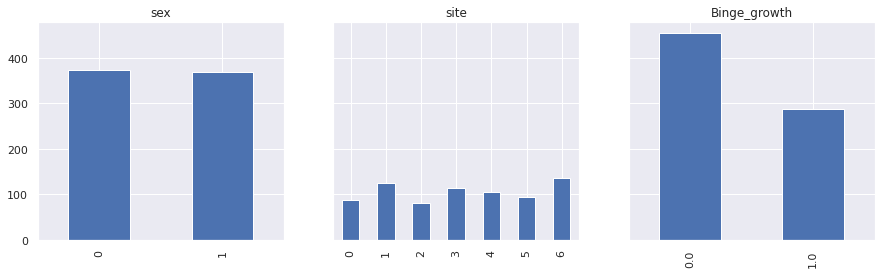

Total subjects = 742


In [96]:
from imagen_dataloader import Imagen

VIZ=False
d = Imagen()
# d.plot_demographics()
dfq = pd.read_csv(qs["ESPAD_GM_FINE"], usecols=["ID", "cluster"])
d.load_label(dfq, col="cluster", viz=VIZ, binarize=True, class0=2, class1=6, y_colname='Binge_growth')
# drop the subjects not in all tp subset 
d.prepare_X("FU2", feature_cols=".+", viz=VIZ) # .*thickness.*
# select valid subjects
# d.df_out = d.df_out[d.df_out.index.isin(valid_sub_ids)]
d.final_df_plot()

In [24]:
# ! rm -vf /ritter/share/data/IMAGEN/h5files/fsstats-all-fu3-binge-gm-l2u6-n668.h5
d.save_h5()

saving h5 file at /ritter/share/data/IMAGEN/h5files/fsstats-all-fu3-binge-growthl2u6-n638.h5


In [90]:
print_h5list("fsstats-all*binge-growth*")

 ('/ritter/share/data/IMAGEN/h5files/fsstats-all-bl-binge-growthl2u6-n1007.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/fsstats-all-fu2-binge-growthl2u6-n781.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/fsstats-all-fu3-binge-growthl2u6-n668.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/fsstats-all-fu3-binge-growthl2u6-n874.h5', 'all'),


In [116]:
import h5py 
d = h5py.File("/ritter/share/data/IMAGEN/h5files/fsstats-all-fu3-binge-gml2u6-n668.h5", "r")
d.keys(), d.attrs.keys(), np.array(d['X']).shape

(<KeysViewHDF5 ['BINGE_GM', 'X', 'i', 'sex', 'site']>,
 <KeysViewHDF5 ['X_col_names', 'confs', 'labels']>,
 (668, 659))

In [ ]:
# for f in sorted(glob(RAW_DIR+"FU3/imaging/freesurfer/*.tsv")):
#     print(f)
# sorted(d.X_col_name)

#### DTI and fsstats combining

In [92]:
tp = "FU2"
df = pd.read_csv(BIDS_DIR+f"fs-stats_{tp}.csv").set_index("ID")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1423 entries, 112288 to 99954902
Columns: 662 entries, rh_bankssts_curvind to lh_insula_curvind
dtypes: float64(659), int64(3)
memory usage: 7.2 MB


In [93]:
df_DTI = pd.read_csv(BIDS_DIR+f"fs-stats_DTI_{tp}.csv").set_index("ID")
new_cols = set(df_DTI.filter(regex="^(?!Unnamed)").columns) - set(df.columns)
df_DTI = df_DTI[new_cols].add_prefix('DTI_')
df = df.add_prefix('T1w_')
df.merge(df_DTI, left_index=True, right_index=True).to_csv(BIDS_DIR+f"sMRI-derivatives_{tp}.csv")

In [184]:
# verify
pd.read_csv(BIDS_DIR+f"sMRI-derivatives_{tp}.csv").info() #.filter(like="T1w_")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Columns: 659 entries, T1w_rh_bankssts_area to T1w_lh_MeanThickness_thickness
dtypes: float64(659)
memory usage: 5.9 MB


#### 5.2 Generate rs-fMRI data

In [32]:
import numpy as np
# perform d.load_mri_() manually
fmri = {}
# Functional connectivity matrices (FCMs) for FU2 can be found in /ritter/share/data/IMAGEN/rsfmri/FU2 
for f in glob("/ritter/share/data/IMAGEN/rsfmri/FU2/*"):
    sub_id, tp, _ = f.split("/")[-1].split("_")
    sub_id = int(sub_id)
    # These operations remove the diagonal and the values above the diagonal that contain double values
    correlation_matrix = np.load(f)
    mask = np.tril(np.ones_like(correlation_matrix), k=-1).astype(bool)
#     plt.matshow(mask)
    x = correlation_matrix[mask]
    fmri.update({sub_id: x})

fmri = pd.DataFrame(fmri).T
fmri.index.rename('ID', inplace=True)
print("total subjects = {}. Features per subject = {}".format(len(fmri), len(fmri.columns)))

total subjects = 1060. Features per subject = 6670


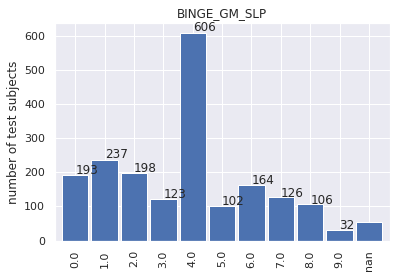

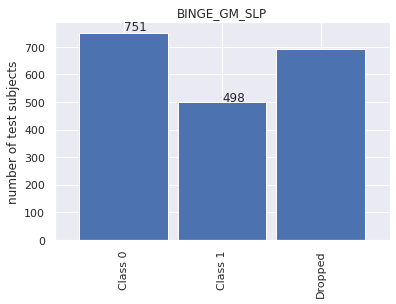

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1940 entries, 22453 to 99954902
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BINGE_GM_SLP  1249 non-null   float64
dtypes: float64(1)
memory usage: 30.3 KB


In [33]:
from imagen_dataloader import Imagen
VIZ=True
d = Imagen()
dfq = pd.read_csv(qs["ESPAD_GM_FINE"], usecols=["ID", "cluster"])
# d.load_label(dfq, col="cluster", viz=VIZ, binarize=True, class0=3, class1=6, y_colname='BINGE_GM').info() 
d.load_label(dfq, col="cluster", viz=VIZ, binarize=True, class0=3, class1=[5,6,7,8], y_colname='BINGE_GM_SLP').info()   
# dfq = pd.read_csv(qs["ESPAD_FU2"], usecols=["19b", "User code"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
# d.load_label(dfq, col="19b", viz=VIZ, binarize=True, class0=2, class1=4, y_colname='BINGE_19yr(2|4)').info()          

Final dataframe prepared. 
Total subjects = 719
Distributions in final dataframe:


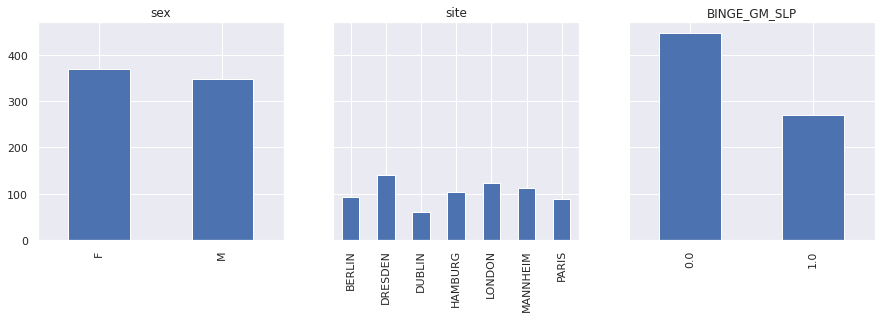

In [35]:
d.hdf5_name_x = "rsfMRI"
d.prepare_X(tp, preloaded_X=fmri)

In [39]:
! rm /ritter/share/data/IMAGEN/h5files/rsfmri-fu2-binge-gm-slpl3u5678-n719.h5
d.save_h5()

saving h5 file at  /ritter/share/data/IMAGEN/h5files/rsfmri-fu2-binge-gm-slpl3u5678-n719.h5


In [42]:
import h5py 
d = h5py.File("/ritter/share/data/IMAGEN/h5files/rsfmri-fu2-binge-gm-slpl3u5678-n719.h5", "r")
d.keys(), dict(d.attrs), np.array(d['X']).shape

(<KeysViewHDF5 ['BINGE_GM_SLP', 'X', 'i', 'sex', 'site']>,
 {'X_col_names': array([   0,    1,    2, ..., 6667, 6668, 6669]),
  'confs': array(['sex', 'site'], dtype=object),
  'labels': array(['BINGE_GM_SLP'], dtype=object)},
 (719, 6670))

#### 5.3 Generate DTI data

Final dataframe prepared. 
Total subjects = 742
Distributions in final dataframe:


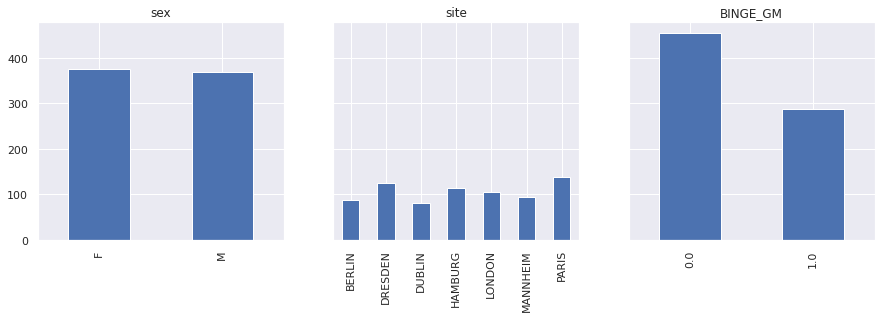

In [94]:
from imagen_dataloader import Imagen
VIZ=False
tp = "FU2"

d = Imagen()
dfq = pd.read_csv(DATA_DIR+"IMAGEN_RAW/2.7/growthcurves/ESPAD/IMGN_ESPAD19b_GM_FINE.csv", 
                  usecols=["ID", "cluster"])
d.load_label(dfq, col="cluster", viz=VIZ, binarize=True, class0=2, class1=6, y_colname='BINGE_GM')
d.prepare_X(tp, mri_col="path_FAsk_DTI")

In [96]:
import nibabel as nib
from scipy.ndimage import zoom

z_factor = 0.525
mask = nib.load(RAW_DIR+f"{tp}/imaging/tbss_dti/classic/stats/mean_FA_skeleton_mask.nii.gz").get_fdata().astype(bool)
if z_factor!=1: mask = zoom(mask.astype(int), z_factor, order=0).astype(bool)
d.save_h5(mri_kwargs={'z_factor': z_factor, 'apply_mask':lambda img: img[mask], 'z_order':0, 'z_prefilter':False})

saving h5 file at  /ritter/share/data/IMAGEN/h5files/faskdti-fu2-z2-binge-gml2u6-n742.h5
Extracting 742 images into a single matrix..


0it [00:00, ?it/s]

In [97]:
# ! ls -la /ritter/share/data/IMAGEN/h5files/faskdti-*

In [ ]:
import h5py 
d = h5py.File("/ritter/share/data/IMAGEN/h5files/faskdti-fu2-z2-binge-gml2u6-n742.h5", "r")
d.keys(), dict(d.attrs), np.array(d['X']).shape

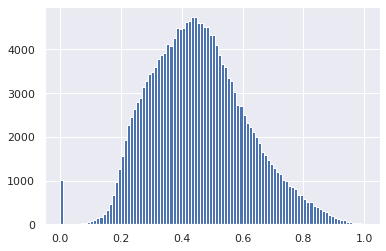

In [62]:
img_hist = np.array(d['X']).ravel()
# img_hist = img_hist[img_hist>=0.01]
plt.hist(img_hist, bins=100)
plt.show()

#### 5.4 Generate sMRI data: whole brain

Final dataframe prepared. 
Total subjects = 102
Distributions in final dataframe:


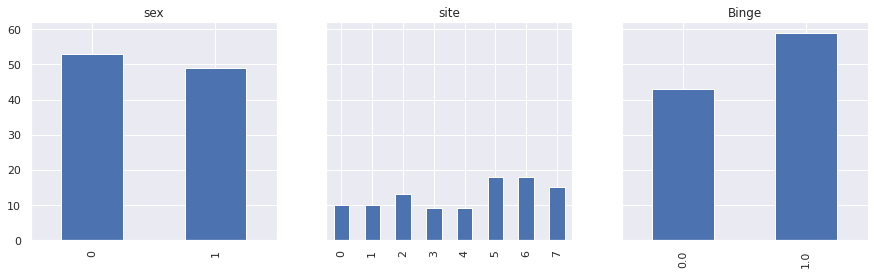

Total subjects = 102


In [13]:
from imagen_dataloader import *
VIZ=False
csv="ESPAD_FU3"
col="19a"
binarize, class0, class1 = True, 3, 6
y_name="Binge"
MRI_tp="FU3"
holdout=True

d = Imagen()
if holdout:
    d.df = d.df_holdout
    d.df_out = pd.DataFrame(index=d.df_holdout.index)
# display(d.plot_demographics())

dfq = pd.read_csv(qs[csv], usecols=["User code", col], dtype={"User code":str})
dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
dfq = dfq.drop("User code", axis=1)
d.load_label(dfq, col=col, viz=VIZ, 
             binarize=binarize, class0=class0, class1=class1, 
             y_colname=y_name)
# drop the subjects not in all tp subset 
d.prepare_X(MRI_tp, mri_col="path_fs-r1-MNInl_T1w", viz=VIZ) # .*thickness.*
# select subjects that have at least 2 data points for growth curve estimation
d.final_df_plot()

In [14]:
d.hdf5_name_x = f"fullbrain-{MRI_tp.lower()}" 
if holdout: d.hdf5_name_x += "-hold"   

In [15]:
# ! rm /ritter/share/data/IMAGEN/h5files/fsr1t1w-fu3-z2-binge-growthl2u6-n668.h5
d.save_h5(mri_kwargs={'z_factor': 0.525, 'z_order':3, 'z_prefilter':True})

saving h5 file at /ritter/share/data/IMAGEN/h5files/fullbrain-fu3-hold-z2-bingel3u6-n102.h5
Extracting 102 images into a single matrix..


  0%|          | 0/102 [00:00<?, ?it/s]

### 6. Visualize DTI FA images

In [177]:
df = pd.read_csv(BIDS_DIR+"participants_FU2.csv", usecols=["ID", "path_FAsk_DTI"]).dropna()
df.info()
df.iloc[0]["path_FAsk_DTI"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 5 to 2314
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             1341 non-null   int64 
 1   path_FAsk_DTI  1341 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


'/ritter/share/data/IMAGEN/IMAGEN_BIDS/sub-000000112288/FU2/anat/sub-000000112288_ses-FU2_rec-FAsk_DTI.nii.gz'

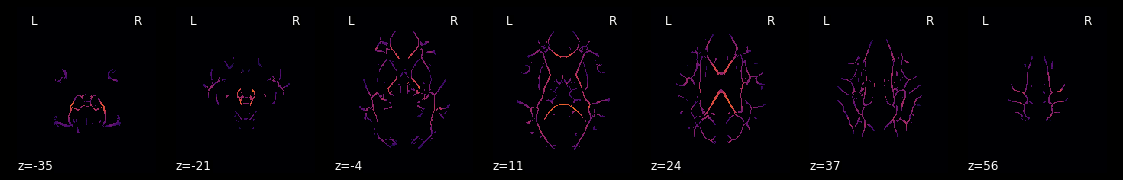

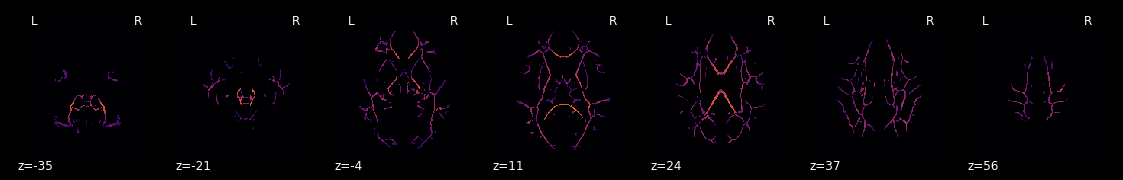

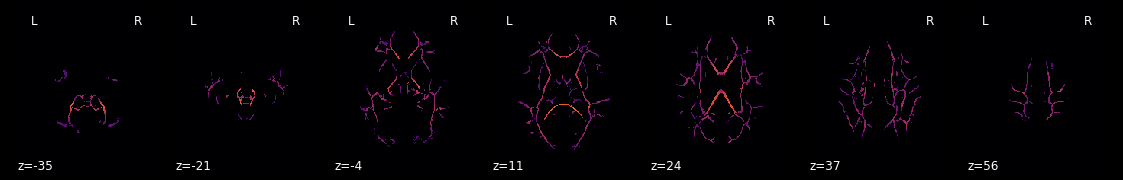

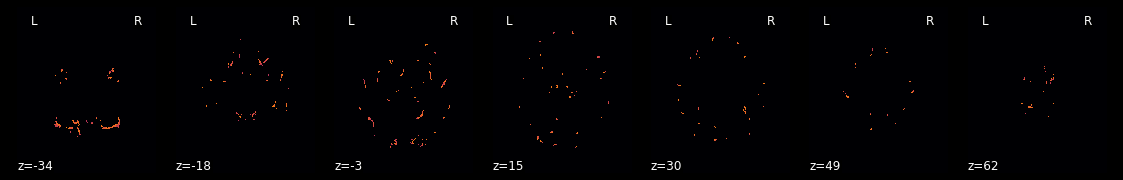

In [193]:
import nibabel as nib
from nilearn import plotting
from scipy.ndimage import zoom
cmap=plt.cm.inferno

# visualize DTI images
for i, row in df.sample().iterrows():
    img = nib.load(row["path_FAsk_DTI"])
    img_arr = img.get_fdata()
    img_arr_t2 = img_arr.copy()
    img_arr_t2[img_arr<0.2] = 0
    img_t2  = nib.Nifti1Image(img_arr_t2, img.affine)
    img_arr_t3 = img_arr.copy()
    img_arr_t3[img_arr<0.3] = 0
    img_t3  = nib.Nifti1Image(img_arr_t3, img.affine)
    img_arr_t23 = img_arr.copy()
    img_arr_t23[np.bitwise_or(img_arr<0.2, img_arr>0.3)] = 0
    img_t23 = nib.Nifti1Image(img_arr_t23, img.affine)
    
    plotting.plot_anat(img    , display_mode='z', cmap=cmap)#, alpha=1)
    plotting.plot_anat(img_t2 , display_mode='z', cmap=cmap)#, alpha=1)
    plotting.plot_anat(img_t3 , display_mode='z', cmap=cmap)#, alpha=1)
    plotting.plot_anat(img_t23, display_mode='z', cmap=cmap)#, alpha=1)

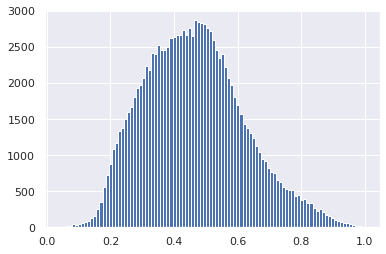

In [173]:
img_hist = img_arr.ravel()
img_hist = img_hist[img_hist>=0.001]
plt.hist(img_hist, bins=100)
plt.show()

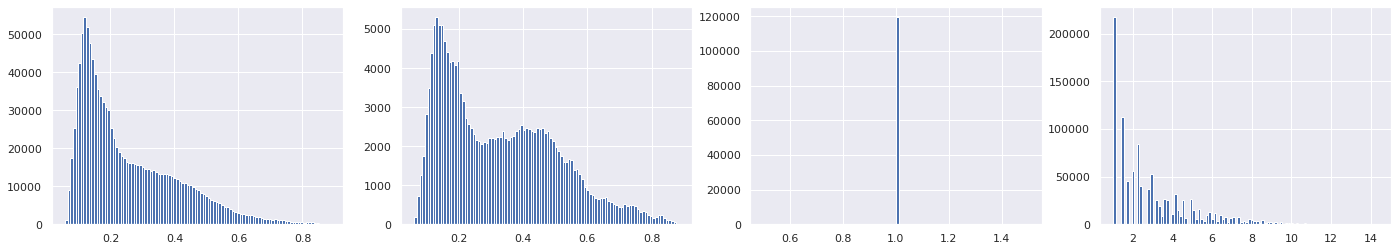

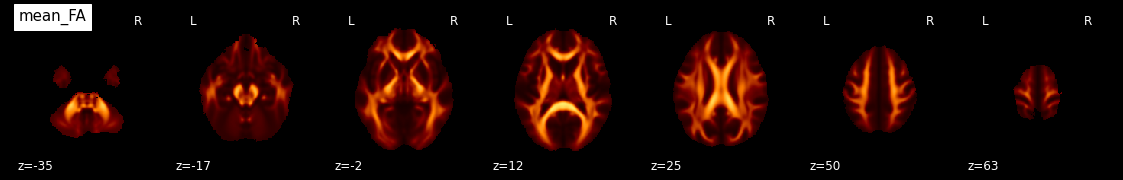

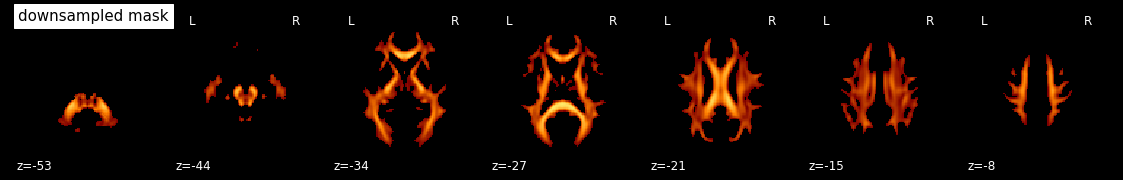

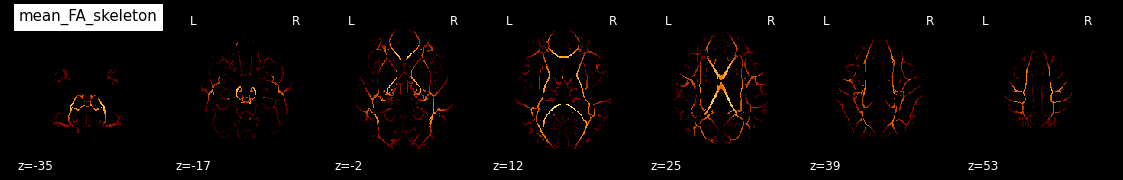

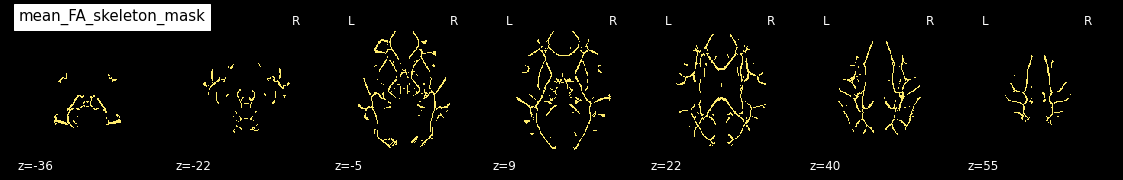

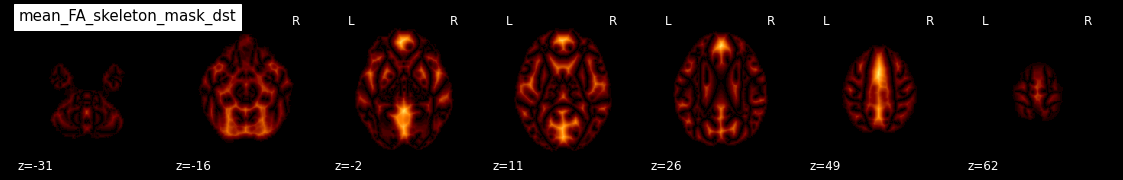

In [377]:
# visualize the average FA skeleton
cmap = plt.cm.afmhot
display_mode = 'z'
files = ["mean_FA.nii.gz", "mean_FA_skeleton.nii.gz", "mean_FA_skeleton_mask.nii.gz", "mean_FA_skeleton_mask_dst.nii.gz"]

f, axes = plt.subplots(1,len(files), figsize=(6*len(files),4))

for i, f in enumerate(files):
    img = nib.load(RAW_DIR+"FU2/imaging/tbss_dti/classic/stats/"+f)
    plotting.plot_anat(img, display_mode=display_mode, cmap=cmap, title=f.split(".")[0])
    img_arr = img.get_fdata()
    if i == 0:
        # downsample
        img_arr_ds = zoom(img_arr, 0.525, order=3, prefilter=True)
        img_arr_ds[img_arr_ds<0.2] = 0
        img_ds = nib.Nifti1Image(img_arr_ds, img.affine)
        plotting.plot_anat(img_ds, display_mode=display_mode, cmap=cmap, title="downsampled mask")
        
    img_hist = img_arr.ravel()
    img_hist = img_hist[img_hist>=0.01]
    axes[i].hist(img_hist, bins=100)

In [ ]:
cmap=plt.cm.afmhot
display_mode='mosaic'

# load a DTI FA skeletal image
img = nib.load(row["path_FAsk_DTI"])
img_arr = img.get_fdata()
plotting.plot_anat(img, display_mode=display_mode, cmap=cmap, title="original FAsk")

# downsampling DTI FA skeletal image
img_arr_ds = zoom(img.get_fdata(), 0.525, order=3, prefilter=False)
img_ds = nib.Nifti1Image(img_arr_ds, img.affine)
plotting.plot_anat(img_ds, display_mode=display_mode, cmap=cmap, title="downsampled by half")
plt.show()

# load the mask
mask = nib.load(RAW_DIR+"FU2/imaging/tbss_dti/classic/stats/mean_FA_skeleton_mask.nii.gz")
# plotting.plot_anat(mask, cmap=cmap)
mask_arr = mask.get_fdata().astype(int)
img_arr_masked = img_arr.copy()
img_arr_masked[~mask_arr] = 0
print("remaining voxels after masking:", np.sum(mask_arr))
img_masked = nib.Nifti1Image(img_arr_masked, img.affine)
plotting.plot_anat(img_masked, display_mode=display_mode, cmap=cmap, title="masked")

# downsampling the mask
mask_arr_ds = zoom(mask_arr, 0.525, order=0, prefilter=False)
# mask_ds = nib.Nifti1Image(mask_arr_ds, mask.affine)
# plotting.plot_anat(mask_ds, cmap=cmap)
img_arr_ds_masked = img_arr_ds.copy()
img_arr_ds_masked[~mask_arr_ds] = 0
print("remaining voxels after masking + downsampling:", np.sum(mask_arr_ds))
img_ds_masked = nib.Nifti1Image(img_arr_ds_masked, img.affine)
plotting.plot_anat(img_ds_masked, display_mode=display_mode, cmap=cmap, title="downsampled and masked")
plt.show()

In [ ]:
# plot value distributions in the images
f, axes = plt.subplots(1,4, figsize=(20,4))
for i, arr in enumerate([img_arr, img_arr_ds, img_arr_masked, img_arr_ds_masked]):
    img_hist = arr.ravel()
    img_hist = img_hist[img_hist>=0.01]
    axes[i].hist(img_hist, bins=100)

In [331]:
! du -sh /ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/*

5,5G	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/all_FA.nii.gz
772M	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/all_FA_skeletonised.nii.gz
5,4G	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/all_MD.nii.gz
745M	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/all_MD_skeletonised.nii.gz
4,3M	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/mean_FA.nii.gz
93K	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/mean_FA_mask.nii.gz
47K	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/mean_FA_mask_orig.nii.gz
4,4M	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/mean_FA_orig.nii.gz
899K	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/mean_FA_skeleton.nii.gz
259K	/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/FU2/imaging/tbss_dti/classic/stats/mean_F